Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [5]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [6]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Чем больше batch_size тем быстрее будет обучаться модель и будет более быстро и эффективно происходить подбор правильных коэффициентов модели при градиентном спуске, поскольку будет больше данных для обучения

Посмотрим на какую-нибудь картинку:

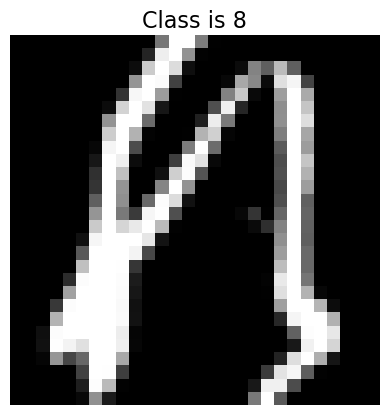

In [7]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





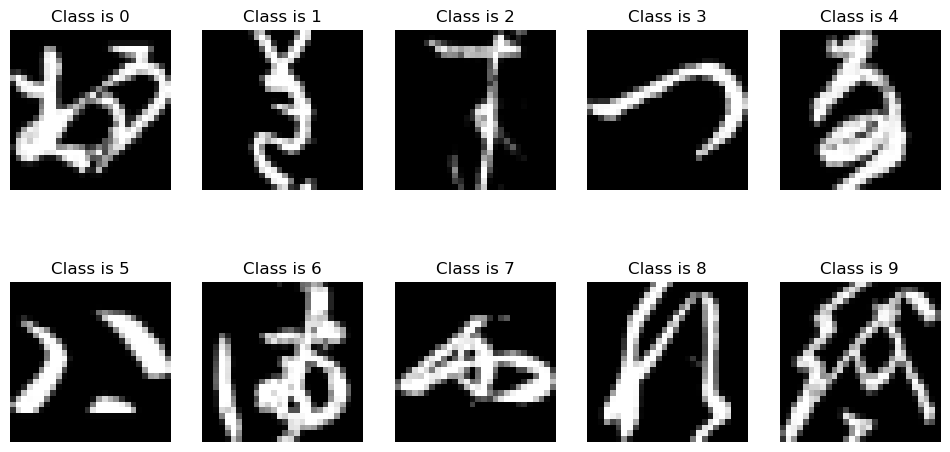

In [8]:
ind_uniq = []
for i in range(10):
  for j in range(50):
    image, label = trainset[j]
    if label == i:
      ind_uniq.append(j)
      break

plt.figure(figsize = (12,6))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  ind = ind_uniq[i]
  plt.imshow(trainset[ind][0].view(28, 28).numpy(), cmap="gray")
  plt.axis("off")
  plt.title(f"Class is {trainset[ind][1]}", fontsize=12)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [9]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, activation = F.relu):
        super().__init__() #  это надо помнить!
        #Задаем линейные слои
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [10]:
print(f"Количество весов: {(28*28*256) + (256*128) + (128*10)}")
print(f"Количество смещений: {256 + 128 + 10}")

Количество весов: 234752
Количество смещений: 394


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [11]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [12]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [13]:
#Сделаем побольше эпох
n_epochs = 20
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # обнуляем градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9099
Epoch=2 loss=0.4447
Epoch=3 loss=0.3568
Epoch=4 loss=0.2992
Epoch=5 loss=0.2597
Epoch=6 loss=0.2255
Epoch=7 loss=0.1970
Epoch=8 loss=0.1726
Epoch=9 loss=0.1513
Epoch=10 loss=0.1345
Epoch=11 loss=0.1187
Epoch=12 loss=0.1041
Epoch=13 loss=0.0922
Epoch=14 loss=0.0809
Epoch=15 loss=0.0723
Epoch=16 loss=0.0636
Epoch=17 loss=0.0558
Epoch=18 loss=0.0485
Epoch=19 loss=0.0423
Epoch=20 loss=0.0368


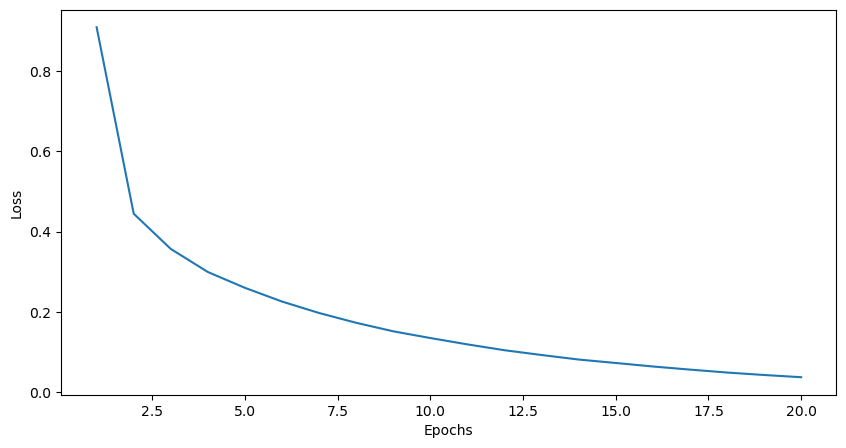

In [14]:
plt.figure(figsize=(10, 5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [15]:
get_accuracy(fc_net, testloader)

0.8959

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [16]:
means = [torch.mean(images) for images, labels in trainloader]
mean = sum(means)/len(trainloader) ## calculate mean
stds = [torch.std(images) for images, labels in trainloader]
std = sum(stds)/len(trainloader) ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

tensor(0.1918) tensor(0.3483)


In [17]:
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform_with_norm)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform_with_norm)

# сделаем DataLoader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [18]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [19]:
n_epochs = 20
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # обнуляем градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6881
Epoch=2 loss=0.3070
Epoch=3 loss=0.2253
Epoch=4 loss=0.1756
Epoch=5 loss=0.1401
Epoch=6 loss=0.1155
Epoch=7 loss=0.0931
Epoch=8 loss=0.0768
Epoch=9 loss=0.0616
Epoch=10 loss=0.0507
Epoch=11 loss=0.0403
Epoch=12 loss=0.0321
Epoch=13 loss=0.0269
Epoch=14 loss=0.0200
Epoch=15 loss=0.0156
Epoch=16 loss=0.0126
Epoch=17 loss=0.0099
Epoch=18 loss=0.0066
Epoch=19 loss=0.0051
Epoch=20 loss=0.0041


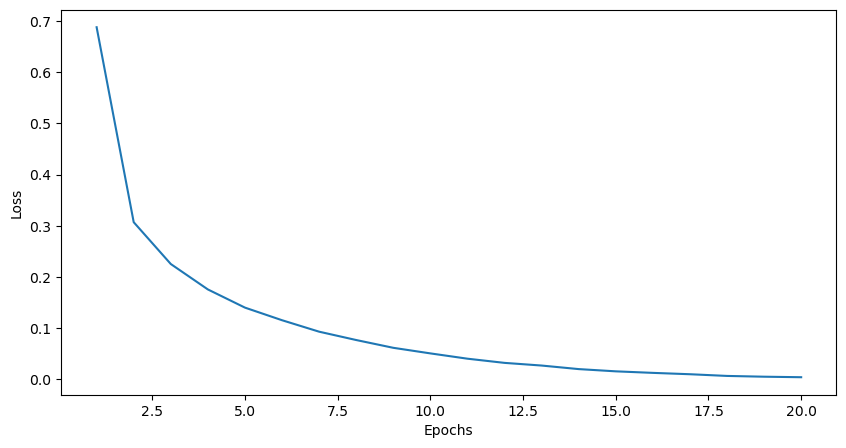

In [20]:
plt.figure(figsize=(10, 5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [21]:
get_accuracy(fc_net, testloader)

0.9022

Как изменилась `accuracy` после нормализации?

После нормализации данных метрика Accuracy стала немного выше.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [22]:
n_epochs = 10

func_activation = [nn.Sigmoid(), nn.GELU(), nn.Tanh()]
for activation in func_activation:
  print(f"func = {activation}")
  print('-'*85)
  #определяем модель
  fc_net = FCNet(activation = activation)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

  loss_history = []
  #Тренируем модель и предсказываем значения
  for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # обнуляем градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        if (epoch+1) in [10,20,30]:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
  accuracy = get_accuracy(fc_net, testloader)
  print(f'Accuracy = {accuracy}\n')


func = Sigmoid()
-------------------------------------------------------------------------------------
Epoch=10 loss=0.1885
Accuracy = 0.8566

func = GELU(approximate='none')
-------------------------------------------------------------------------------------
Epoch=10 loss=0.0409
Accuracy = 0.9014

func = Tanh()
-------------------------------------------------------------------------------------
Epoch=10 loss=0.0314
Accuracy = 0.9


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Лучше всего получилось с GELU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [23]:
optimisators  = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.RMSprop]
n_epochs = 10
activation = nn.GELU()

for optimisator in optimisators:
    print('-'*85)
    print(f'optimisator = {optimisator}')
    fc_net = FCNet(activation = activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimisator(fc_net.parameters(), lr=3e-4)

    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # обнуляем градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        if (epoch+1) in [10,20,30]:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    accuracy = get_accuracy(fc_net, testloader)
    print(f'Accuracy = {accuracy}\n')

-------------------------------------------------------------------------------------
optimisator = <class 'torch.optim.adam.Adam'>
Epoch=10 loss=0.0392
Accuracy = 0.9037

-------------------------------------------------------------------------------------
optimisator = <class 'torch.optim.adagrad.Adagrad'>
Epoch=10 loss=0.4945
Accuracy = 0.7208

-------------------------------------------------------------------------------------
optimisator = <class 'torch.optim.rmsprop.RMSprop'>
Epoch=10 loss=0.0310
Accuracy = 0.9024


### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [24]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [25]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

print('nn.relu')
print('-'*85)

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # обнуляем градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')

nn.relu
-------------------------------------------------------------------------------------
Epoch=1 loss=0.6891
Epoch=2 loss=0.2987
Epoch=3 loss=0.2211
Epoch=4 loss=0.1698
Epoch=5 loss=0.1354
Epoch=6 loss=0.1096
Epoch=7 loss=0.0895
Epoch=8 loss=0.0721
Epoch=9 loss=0.0600
Epoch=10 loss=0.0472
Accuracy = 0.8989


In [31]:
fc_net = FCNet(activation = CustomReLU())
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

print('CustomRelu')
print('-'*85)
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # обнуляем градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')


CustomRelu
-------------------------------------------------------------------------------------
Epoch=1 loss=0.6745
Epoch=2 loss=0.3034
Epoch=3 loss=0.2267
Epoch=4 loss=0.1777
Epoch=5 loss=0.1434
Epoch=6 loss=0.1164
Epoch=7 loss=0.0956
Epoch=8 loss=0.0787
Epoch=9 loss=0.0642
Epoch=10 loss=0.0526
Accuracy = 0.8941


Кастомный Relu работает хорошо

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Изображения сгенерированы с помощью GigaChat, поскольку ruDALLE отказался работать

Кот скрипач летит в космос


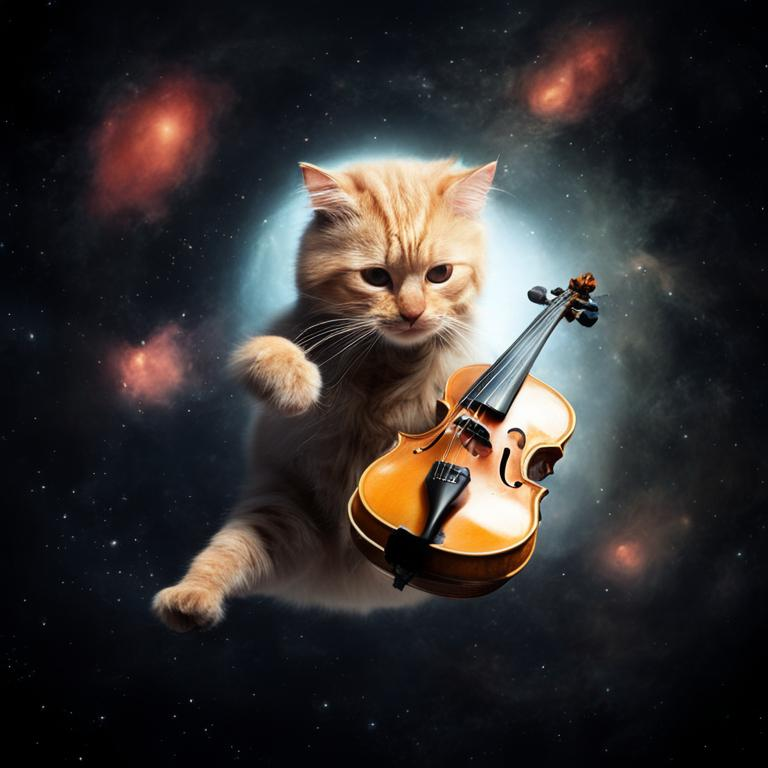

In [32]:
from IPython.display import Image
print("Кот скрипач летит в космос")
Image('img/cat.jpg')

Кот-биоинформатик держит в заложниках Шерлока Холмса


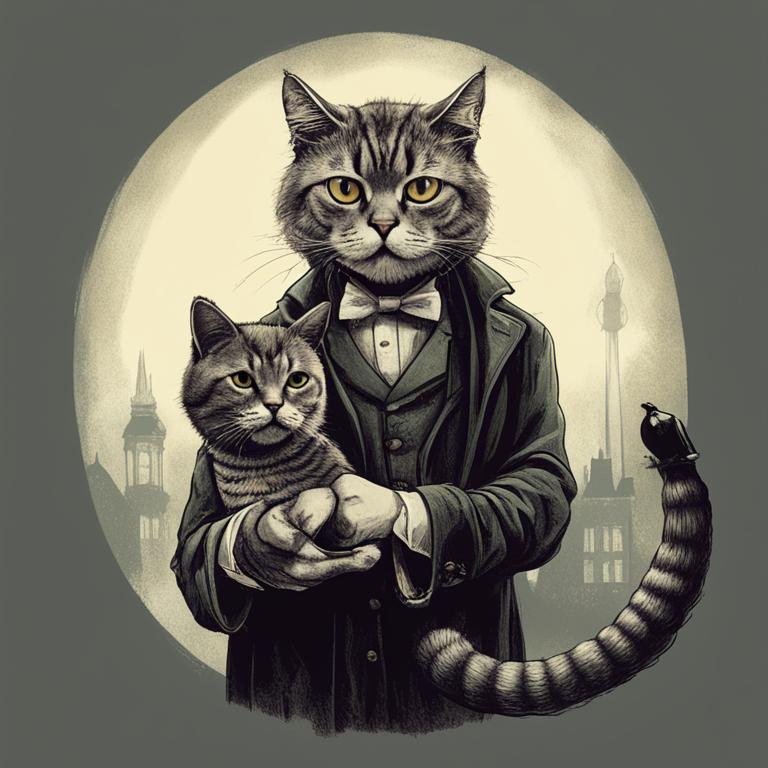

In [33]:
print("Кот-биоинформатик держит в заложниках Шерлока Холмса")
Image('img/cat2.jpg')

Коты захватывают мир


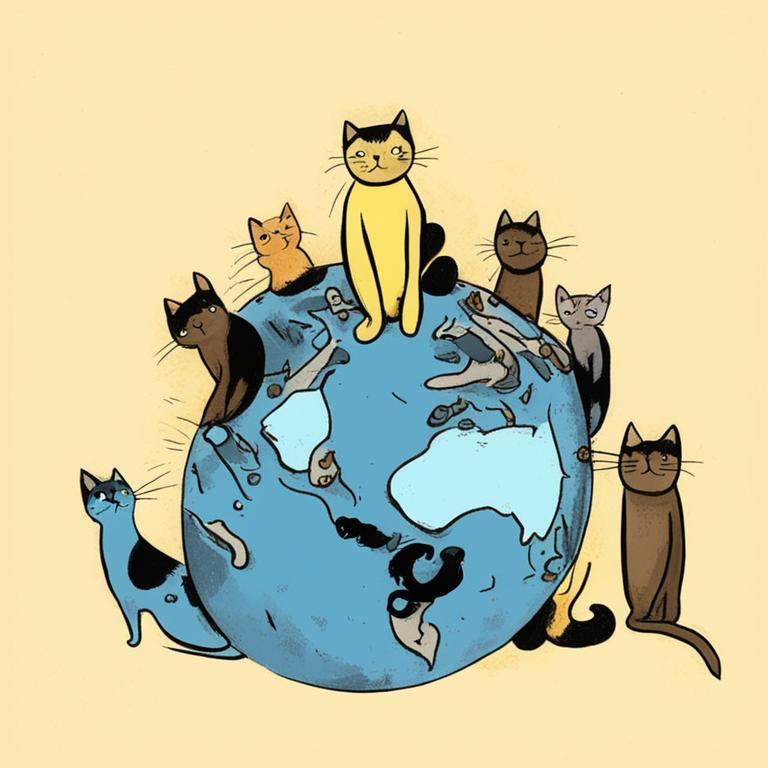

In [34]:
print("Коты захватывают мир")
Image('img/cat3.jpg')